In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
print(cv2.__version__)

4.8.1


In [44]:
def get_image_paths(root_folder, image_extensions=('.jpg', '.jpeg', '.png')):
    image_paths = []
    for foldername, __, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith(image_extensions):
                image_paths.append(os.path.join(foldername, filename))
    return image_paths

# Specify the root folder
root_folder = 'data'

# Get image paths
image_paths = get_image_paths(root_folder)

In [45]:
def process_images(image_paths):
    for image_path in image_paths:
        # Read the image
        gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if gray_image.shape != (64, 64):
            # Apply blur
            blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

            # Resize to 64x64
            resized_image = cv2.resize(blurred_image, (64, 64))

            # Overwrite the image
            cv2.imwrite(image_path, resized_image)

process_images(image_paths)

1


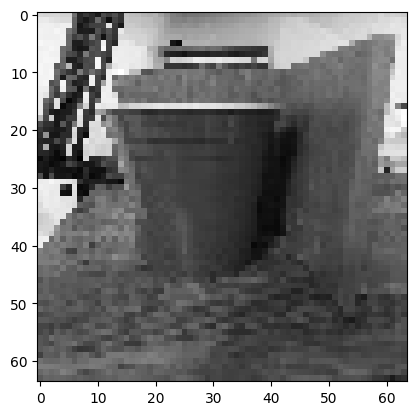

(30, 64, 64)
[[0.8        0.78823529 0.79215686 ... 0.77647059 0.76470588 0.75294118]
 [0.85490196 0.85882353 0.83529412 ... 0.81568627 0.82745098 0.80784314]
 [0.87843137 0.88235294 0.87843137 ... 0.84705882 0.83529412 0.82745098]
 ...
 [0.46666667 0.4627451  0.45882353 ... 0.25490196 0.32156863 0.32941176]
 [0.39215686 0.42745098 0.39607843 ... 0.29803922 0.32156863 0.27058824]
 [0.3372549  0.38431373 0.37254902 ... 0.10980392 0.18039216 0.19607843]]


In [46]:
X = np.array(list(map(lambda path: cv2.imread(path, cv2.IMREAD_GRAYSCALE), image_paths)))
X = X / 255.0
Y = np.array([1 if 'cup' in path else 0 for path in image_paths])

display = 3
print(Y[display])
plt.imshow(X[display], cmap='gray')
plt.show()
print(X.shape)
print(X[display])

In [47]:
# Suppress TensorFlow deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with less verbosity
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc}")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 12544)             0         
                                                                 
 dense_12 (Dense)            (None, 128)              

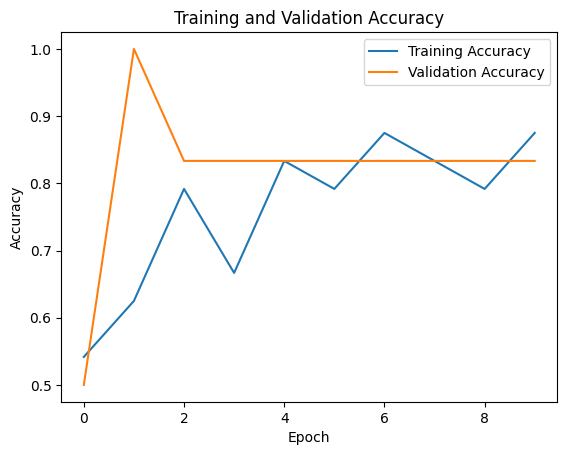

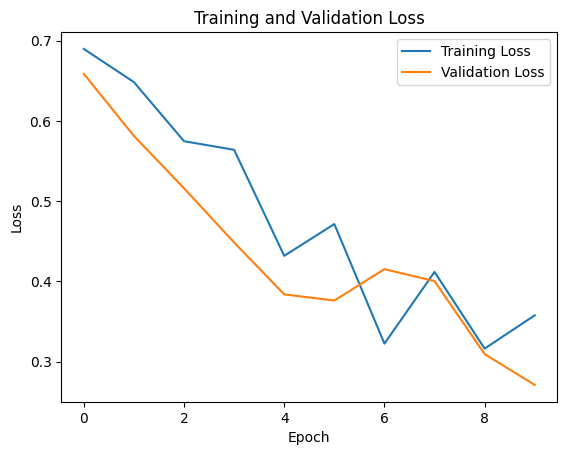

In [48]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
# Save the trained model
model.save('model.h5')